In [855]:
import os
import random
from glob import glob

from tqdm import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2 as cv

from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# dataset exploration

In [12]:
def plot(img: np.ndarray):
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.show()

In [373]:
def get_blanket(images: np.ndarray, fixed_size=None):
    N = len(images)
    P = images.shape[1]
    H, W = 1, 1
    if N <= 0:
        return
    elif 0 < N < 6:
        H, W = 1, N
    else:
        H = int(np.round(np.sqrt(N * 3 / 4)))
        W = int(np.floor(N / H))
    if fixed_size is not None:
        H, W = fixed_size
    
    blanket = np.zeros((H * P, W * P))
    for i in range(N):
        y = i // W
        x = i % W
        blanket[y*P:(y+1)*P, x*P:(x+1)*P] = images[i]
    
    return blanket

In [374]:
def plot_blanket(images: np.ndarray):
    blanket = get_blanket(images)
    plt.figure(figsize=(12, 8))
    plt.imshow(blanket, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
    plt.show()

In [378]:
def save_blanket(images: np.ndarray, filename: str, fixed_size=None):
    blanket = get_blanket(images, fixed_size)
    cv.imwrite(filename, blanket)

In [42]:
X = []
for fname in sorted(glob('train/*.jpg')):
    img = cv.imread(fname, cv.IMREAD_GRAYSCALE)
    X.append(img)
X = np.array(X)

In [43]:
print('Total {} train images of size {}.'.format(X.shape[0], X.shape[1:]))

Total 3600 train images of size (24, 24).


#### let's look at more eyes

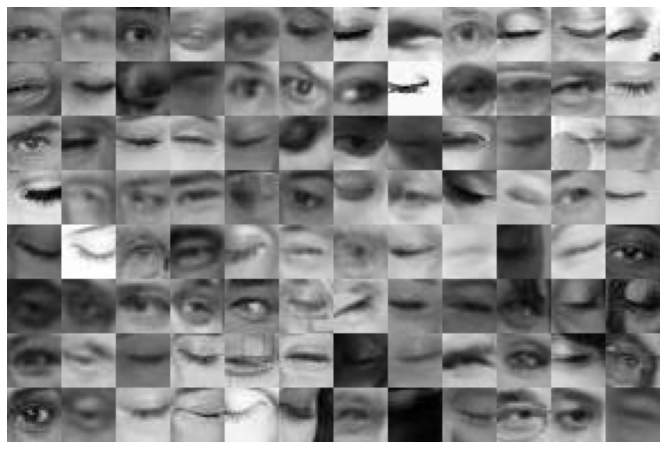

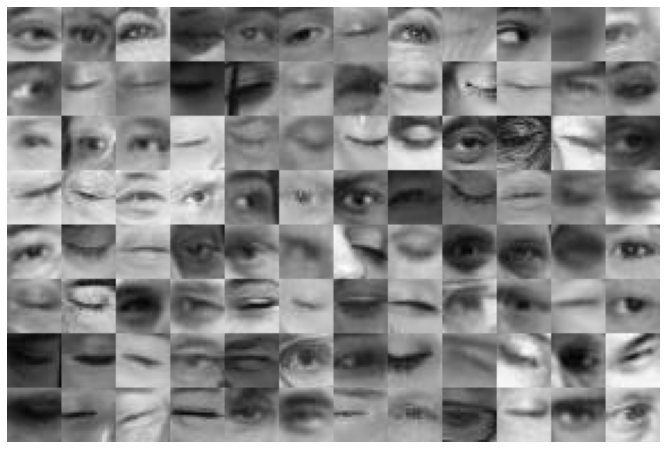

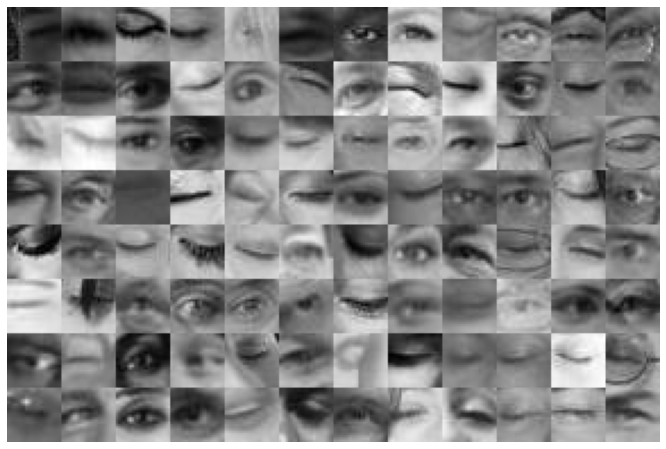

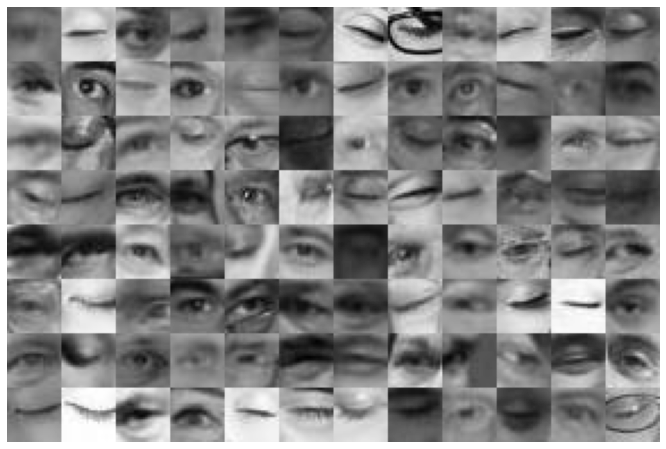

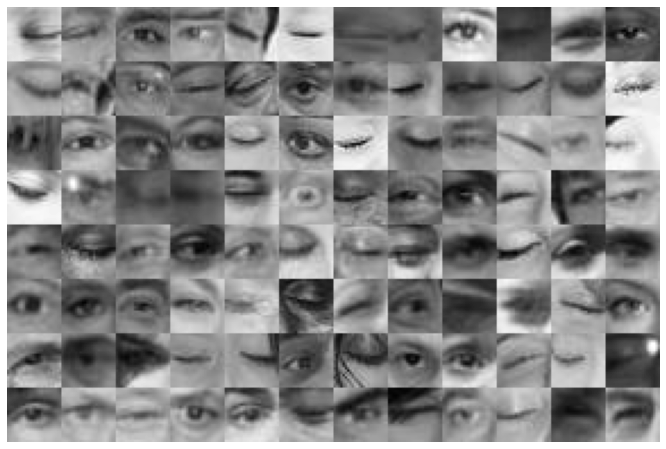

In [46]:
for i in range(5):
    plot_blanket(X[i*96:(i+1)*96])

# ideas

* ~haarcascade (OpenCV)~

* EAR + landmarks

* По ключевым точкам на основе dlib 

https://www.pyimagesearch.com/2017/04/10/detect-eyes-nose-lips-jaw-dlib-opencv-python/

* По ключевым точкам на основе OpenCV

* Как классическая кластеризация (на основе простых признаков, или на основе сложных признаков)

* Как supervised classification

* Как N-shot K-way

* Как unsupervised learning

* Как unsupervised clusterisation

* Как 1-class SVM

* ...

# Метрики по всей разметке

In [511]:
df = pd.read_csv('./assets.csv')
Y_true = list(df['label'])
Y_true = np.array(Y_true)

In [432]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [434]:
def calc_metrics(y_true, y_pred):
    print('acc: {:.5f}'.format(accuracy_score(y_true, y_pred)))
    print('pre: {:.5f}'.format(precision_score(y_true, y_pred)))    
    print('rec: {:.5f}'.format(recall_score(y_true, y_pred)))    
    print('f1 : {:.5f}'.format(f1_score(y_true, y_pred)))        

# По ключевым точкам на основе OpenCV (baseline)

In [532]:
def norm_numpy(img):
    ar = img.astype(np.float32)
    mean = img.mean()
    vr = img.std()
    out = (ar - mean) / vr
    return out

https://www.geeksforgeeks.org/python-eye-blink-detection-project/

In [425]:
eye_cascade = cv.CascadeClassifier('haarcascade_eye_tree_eyeglasses.xml')

In [518]:
def classify_haarcascade(img, scale=1.06):
    eyes = eye_cascade.detectMultiScale(img, scale, 0, minSize=(4,4))
    return len(eyes) > 0

In [519]:
pred_haarcascade = np.zeros(len(X))
for i in tqdm(range(len(X))):
    pred_haarcascade[i] = classify_haarcascade(X[i])

100%|██████████| 3600/3600 [00:00<00:00, 3996.39it/s]


In [520]:
X_pred_eye = X[pred_haarcascade > 0.5]
X_pred_blink = X[pred_haarcascade < 0.5]

X_pred_eye.shape, X_pred_blink.shape

((1718, 24, 24), (1882, 24, 24))

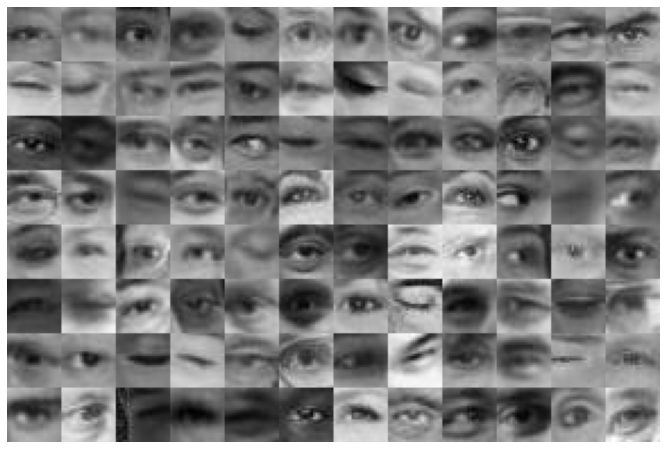

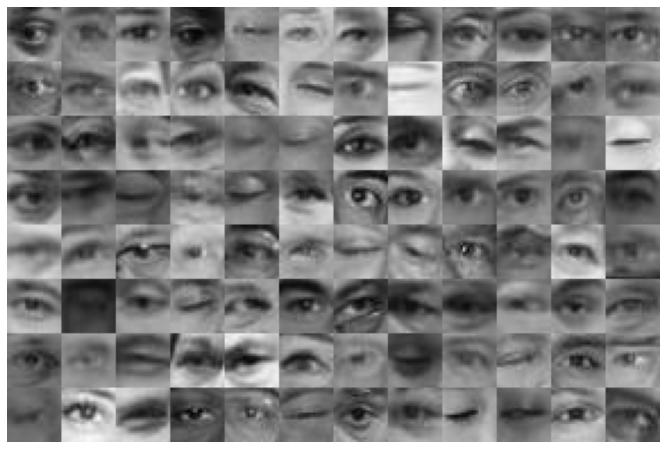

In [521]:
plot_blanket(X_pred_eye[:96])
plot_blanket(X_pred_eye[96:2*96])

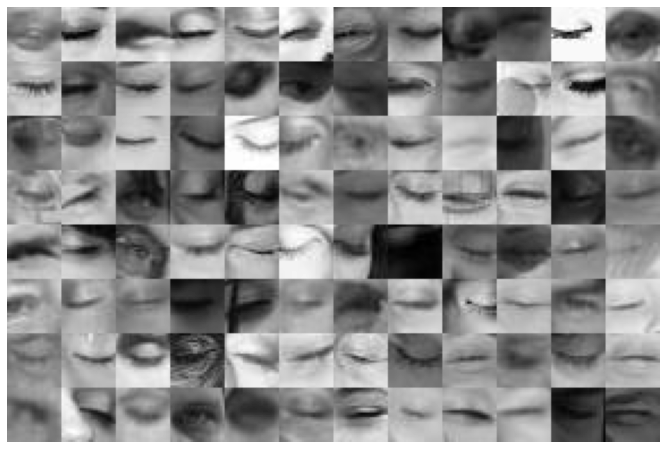

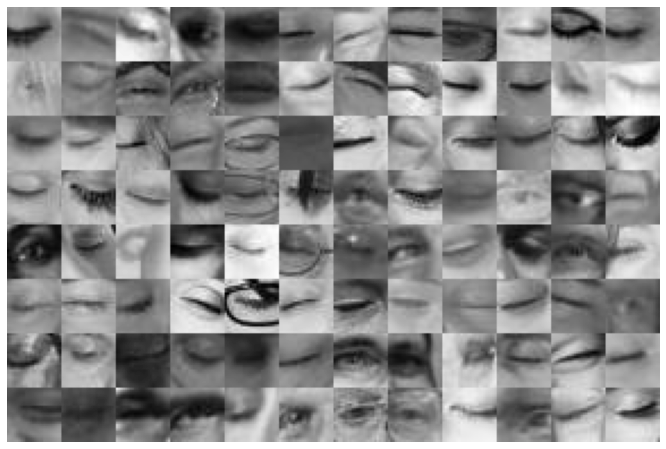

In [522]:
plot_blanket(X_pred_blink[:96])
plot_blanket(X_pred_blink[96:2*96])

In [523]:
calc_metrics(Y_true, pred_haarcascade)

acc: 0.83694
pre: 0.81257
rec: 0.84046
f1 : 0.82628


# Look at t-SNE & HOG

In [174]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [200]:
tsne = TSNE(n_jobs=12)
X_tsne = tsne.fit_transform(X.reshape((len(X), -1)))

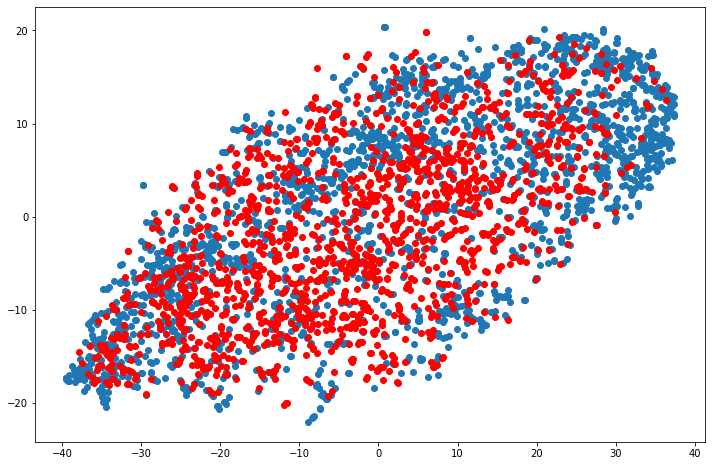

In [201]:
plt.figure(figsize=(12, 8))
plt.scatter(X_tsne[pred_haarcascade < 0.5][:, 0], X_tsne[pred_haarcascade < 0.5][:, 1])
plt.scatter(X_tsne[pred_haarcascade > 0.5][:, 0], X_tsne[pred_haarcascade > 0.5][:, 1], color='red')
plt.show()

well, it looks like trash. What about HOG?

In [202]:
from skimage.feature import hog

In [526]:
def norm_0_1_numpy(img):
    ar = img.astype(np.float32)
    mn = np.min(ar)
    mx = np.max(ar)
    norm = (ar - mn) * (1.0 / (mx - mn))
    return norm

In [527]:
def get_hog(img):
    hog_image = hog(norm_0_1_numpy(img), orientations=9, pixels_per_cell=(6, 6), cells_per_block=(2, 2), multichannel=False)
    return hog_image

In [213]:
X_hog = np.array([get_hog(X[i]) for i in range(len(X))])

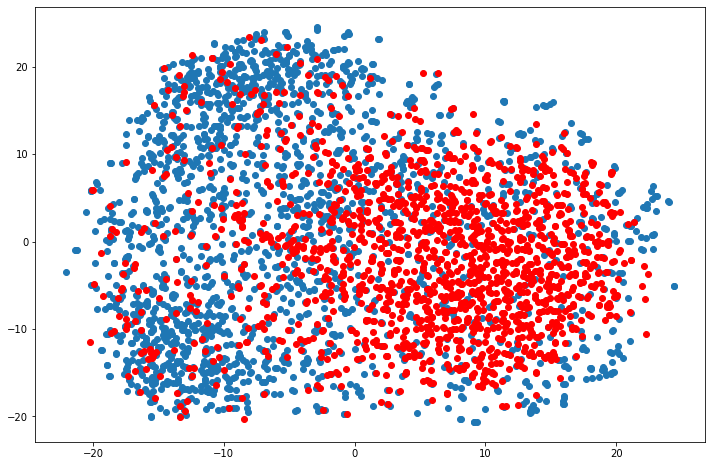

In [214]:
X_tsne = tsne.fit_transform(X_hog)
plt.figure(figsize=(12, 8))
plt.scatter(X_tsne[pred_haarcascade < 0.5][:, 0], X_tsne[pred_haarcascade < 0.5][:, 1])
plt.scatter(X_tsne[pred_haarcascade > 0.5][:, 0], X_tsne[pred_haarcascade > 0.5][:, 1], color='red')
plt.show()

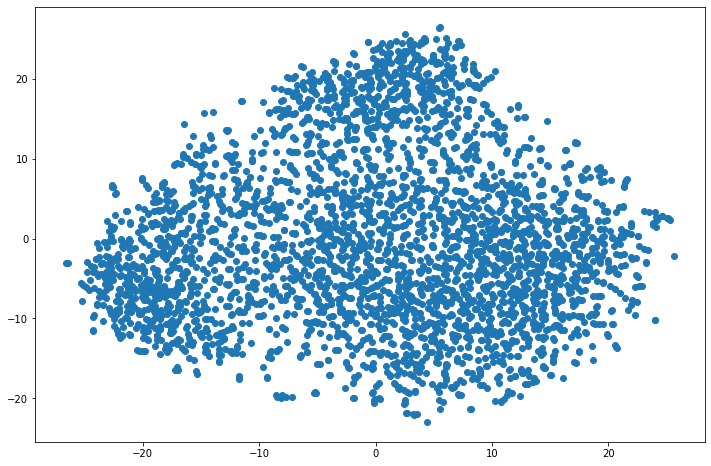

In [207]:
X_tsne = tsne.fit_transform(X_hog)
plt.figure(figsize=(12, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()

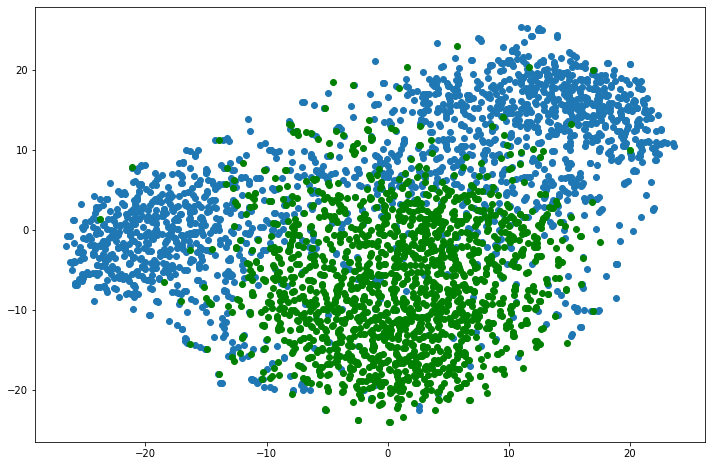

In [512]:
X_tsne = tsne.fit_transform(X_hog)
plt.figure(figsize=(12, 8))
plt.scatter(X_tsne[Y_true < 0.5][:, 0], X_tsne[Y_true < 0.5][:, 1])
plt.scatter(X_tsne[Y_true > 0.5][:, 0], X_tsne[Y_true > 0.5][:, 1], color='green')
plt.show()

# supervised classification pretrained model-zoo

In [215]:
!pip install onnx2pytorch

In [216]:
import onnx
from onnx2pytorch import ConvertModel

In [220]:
onnx_model = onnx.load('./open-closed-eye.onnx')

NotImplementedError: Conversion not implemented for op_type=ReduceSum.

In [239]:
onnx_model.graph.node[10].op_type = 'Sum'

In [240]:
pytorch_model = ConvertModel(onnx_model)

Automatic inference of operator: sum


In [246]:
import torch
import torch.nn as nn

In [250]:
simple_clf = nn.Sequential(*list(pytorch_model.children())[:-1], 
                           nn.Softmax())

In [251]:
simple_clf

Sequential(
  (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=False)
  (2): ReLU(inplace=True)
  (3): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=False)
  (5): ReLU(inplace=True)
  (6): Conv2d(20, 50, kernel_size=(3, 3), stride=(1, 1))
  (7): Conv2d(50, 2, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (8): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=(0, 0), dilation=1, ceil_mode=False)
  (9): Softmax(dim=None)
)

In [307]:
torch.save(simple_clf.state_dict(), './simple_clf.pt')

In [474]:
TFMS1 = transforms.Compose([
     transforms.ToPILImage(),
     transforms.Resize((32, 32)),
     transforms.ToTensor(),
     transforms.ConvertImageDtype(torch.float),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [479]:
def classify_openclosedeye(img, scale=0.75):
    with torch.no_grad():
        t = TFMS1(np.stack([img, img, img], axis=0))
#         print(t)
        t = t.unsqueeze(0)
        p = simple_clf(t).numpy().ravel()[1]
        return p > 0.5

In [537]:
def classify_openclosedeye(img, scale=0.5):
    with torch.no_grad():
        rsz_img = cv.resize(img, (32, 32)).astype(np.float)
#         plot(rsz_img)
        rsz_img = (np.stack([rsz_img, rsz_img, rsz_img], axis=0) / 255.0 - 0.64) * scale
        t = torch.tensor(rsz_img, dtype=torch.float).unsqueeze(0)
        p = simple_clf(t).numpy().ravel()[1]
        return p > 0.5

In [538]:
classify_openclosedeye(X[18])

True

In [539]:
pred_openclosedeye = np.zeros(len(X))
for i in tqdm(range(len(X))):
    pred_openclosedeye[i] = classify_openclosedeye(X[i])

100%|██████████| 3600/3600 [00:03<00:00, 1004.76it/s]


In [540]:
X_pred_eye = X[pred_openclosedeye > 0.5]
X_pred_blink = X[pred_openclosedeye < 0.5]

X_pred_eye.shape, X_pred_blink.shape

((1729, 24, 24), (1871, 24, 24))

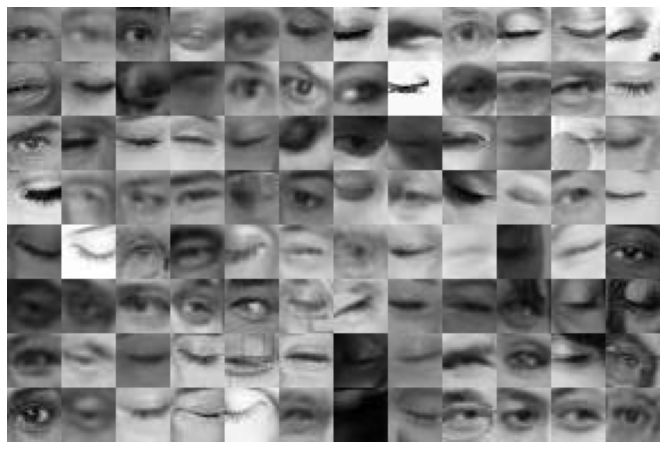

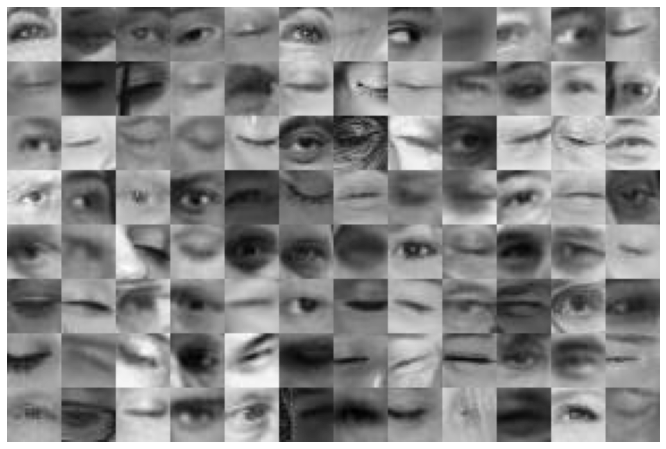

In [536]:
plot_blanket(X_pred_eye[:96])
plot_blanket(X_pred_eye[96:2*96])

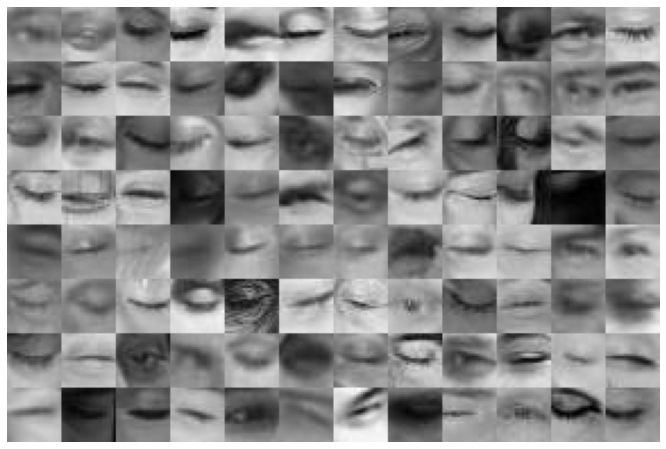

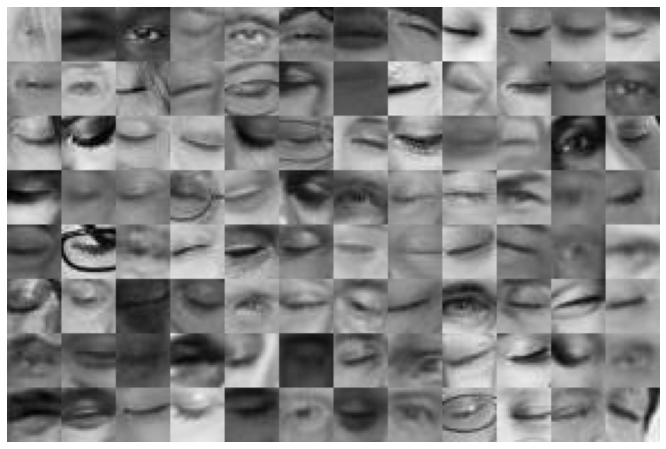

In [488]:
plot_blanket(X_pred_blink[:96])
plot_blanket(X_pred_blink[96:2*96])

In [489]:
calc_metrics(Y_true, pred_openclosedeye)

acc: 0.76472
pre: 0.71626
rec: 0.81156
f1 : 0.76094


### hyperparam

In [509]:
# for scale in np.linspace(0.25, 1.0, 16):
for scale in np.linspace(0.45, 0.55, 11):
    
    print('-'*80)
    print(' [  {}  ]'.format(scale))
    pred_openclosedeye_s = np.zeros(len(X))
    for i in tqdm(range(len(X))):
        pred_openclosedeye_s[i] = classify_openclosedeye(X[i], scale=scale)
    calc_metrics(Y_true, pred_openclosedeye_s)

  3%|▎         | 95/3600 [00:00<00:03, 944.99it/s]

--------------------------------------------------------------------------------
 [  0.45  ]


  3%|▎         | 103/3600 [00:00<00:03, 1024.29it/s]

acc: 0.83944
pre: 0.85003
rec: 0.79169
f1 : 0.81983
--------------------------------------------------------------------------------
 [  0.46  ]


  3%|▎         | 124/3600 [00:00<00:02, 1229.27it/s]

acc: 0.84472
pre: 0.84352
rec: 0.81457
f1 : 0.82879
--------------------------------------------------------------------------------
 [  0.47000000000000003  ]


  3%|▎         | 103/3600 [00:00<00:03, 1022.19it/s]

acc: 0.84667
pre: 0.83626
rec: 0.83022
f1 : 0.83323
--------------------------------------------------------------------------------
 [  0.48000000000000004  ]


  3%|▎         | 101/3600 [00:00<00:03, 1001.76it/s]

acc: 0.84833
pre: 0.83086
rec: 0.84287
f1 : 0.83682
--------------------------------------------------------------------------------
 [  0.49000000000000005  ]


  3%|▎         | 98/3600 [00:00<00:03, 974.92it/s]

acc: 0.84889
pre: 0.82795
rec: 0.84889
f1 : 0.83829
--------------------------------------------------------------------------------
 [  0.5  ]


  4%|▎         | 130/3600 [00:00<00:02, 1299.98it/s]

acc: 0.84778
pre: 0.82186
rec: 0.85551
f1 : 0.83835
--------------------------------------------------------------------------------
 [  0.51  ]


  3%|▎         | 103/3600 [00:00<00:03, 1021.36it/s]

acc: 0.84639
pre: 0.81657
rec: 0.86033
f1 : 0.83788
--------------------------------------------------------------------------------
 [  0.52  ]


  3%|▎         | 102/3600 [00:00<00:03, 1014.59it/s]

acc: 0.84306
pre: 0.80926
rec: 0.86334
f1 : 0.83542
--------------------------------------------------------------------------------
 [  0.53  ]


  3%|▎         | 105/3600 [00:00<00:03, 1047.84it/s]

acc: 0.84083
pre: 0.80222
rec: 0.86936
f1 : 0.83444
--------------------------------------------------------------------------------
 [  0.54  ]


  3%|▎         | 106/3600 [00:00<00:03, 1055.42it/s]

acc: 0.84083
pre: 0.79890
rec: 0.87538
f1 : 0.83539
--------------------------------------------------------------------------------
 [  0.55  ]


100%|██████████| 3600/3600 [00:03<00:00, 1050.33it/s]

acc: 0.83972
pre: 0.79617
rec: 0.87718
f1 : 0.83472


# Получение датасета для разметки

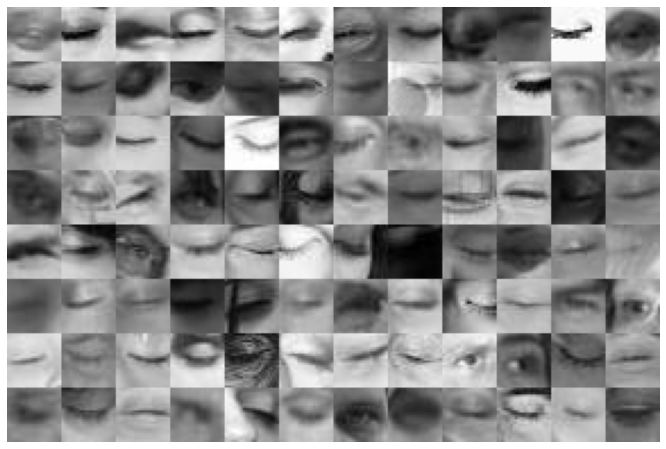

In [376]:
plot_blanket(X_pred_blink[:96])

In [392]:
for i in range(int(np.ceil(X_pred_blink.shape[0] / 96))):
    save_blanket(X_pred_blink[i*96:(i+1)*96], './markup/0/{:02d}.png'.format(i), (8, 12))

In [395]:
for i in range(int(np.ceil(X_pred_eye.shape[0] / 96))):
    save_blanket(X_pred_eye[i*96:(i+1)*96], './markup/1/{:02d}.png'.format(i), (8, 12))

In [524]:
# !tar -cvf markup.tar ./markup/

In [525]:
# !unzip markup_assessed.zip

# Получение разметки из файлов

In [399]:
np.array([[1, 2], [2, 3], [1, 2]]) == np.array([1, 1])

array([[ True, False],
       [False, False],
       [ True, False]])

In [401]:
BLANKET0 = []
for fname in sorted(glob('./markup_assessed/0/*.png')):
    img = cv.imread(fname)[:, :, ::-1]
    BLANKET0.append(img)
BLANKET0 = np.concatenate(BLANKET0, axis=0)

In [402]:
BLANKET1 = []
for fname in sorted(glob('./markup_assessed/1/*.png')):
    img = cv.imread(fname)[:, :, ::-1]
    BLANKET1.append(img)
BLANKET1 = np.concatenate(BLANKET1, axis=0)

In [403]:
def get_red(where, index):
    y = index // 12
    x = index % 12
    slc = where[y*24:(y+1)*24, x*24:(x+1)*24]
    return ((slc[:, :, 0] == 255) * (slc[:, :, 1] == 0) * (slc[:, :, 2] == 0)).sum()

In [415]:
Y = []
index0 = 0
index1 = 0
for index, fname in enumerate(sorted(glob('train/*.jpg'))):
    if pred_haarcascade[index] > 0.5:
        cls = 1
        if get_red(BLANKET1, index1):
            cls = 0
        index1 += 1
    else:
        cls = 0
        if get_red(BLANKET0, index0):
            cls = 1
        index0 += 1
    Y.append(cls)
Y = np.array(Y)

In [416]:
X_true_eye = X[Y > 0.5]
X_true_blink = X[Y < 0.5]

X_true_eye.shape, X_true_blink.shape

((1661, 24, 24), (1939, 24, 24))

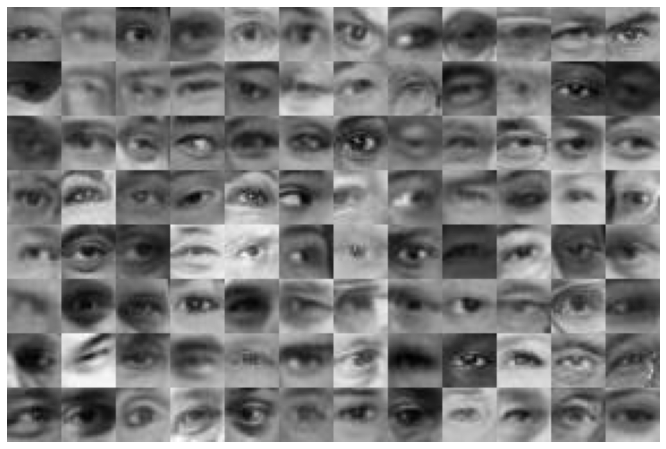

In [417]:
plot_blanket(X_true_eye[:96])

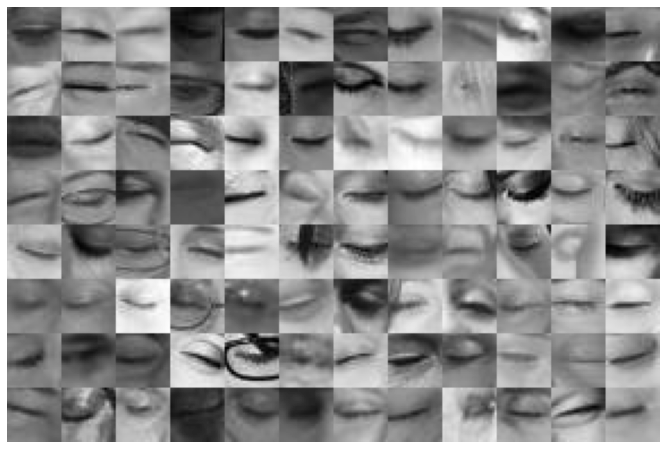

In [418]:
plot_blanket(X_true_blink[1*96:2*96])

In [420]:
csv = []
for index, fname in enumerate(sorted(glob('train/*.jpg'))):
    csv.append({'label': Y[index],
                'fname': fname})

In [423]:
csv = pd.DataFrame(csv)

In [424]:
csv.to_csv('./assets.csv')

# Supervised classification - custom neural network

### dataset

In [1111]:
def parse_mrl_filename(fname):
    bname = os.path.splitext(os.path.basename(fname))[0]
    spt = bname.split('_')
    return spt[4] == '1'

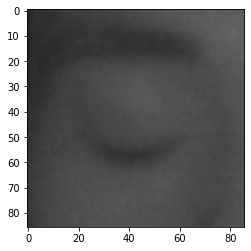

False


In [1112]:
mrl_eyes_img = []
mrl_eyes_label = []
for fname in sorted(glob('./mrlEyes_2018_01/*/*.png')):
    img = cv.imread(fname, cv.IMREAD_GRAYSCALE)
    plot(img)
    print(parse_mrl_filename(fname))
    break

In [1113]:
import albumentations as A

In [1114]:
ATFMS_MRL1 = A.Compose([
    A.CLAHE(clip_limit=1.2, tile_grid_size=(4, 4), p=0.25),
    A.HorizontalFlip(0.5),
    A.Transpose(p=0.01),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.25, rotate_limit=15, p=0.5),
    A.Normalize(mean=0.5, std=0.5),
    A.Resize(24, 24)
])

In [1115]:
ATFMS_MRL2 = A.Compose([
    A.CLAHE(clip_limit=1.2, tile_grid_size=(4, 4), p=0.25),
    A.HorizontalFlip(0.5),
    A.CenterCrop(70, 70),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.25, rotate_limit=15, p=0.5),
    A.Normalize(mean=0.5, std=0.5),
    A.Resize(24, 24)
])

In [1116]:
ATFMS_CUSTOM = A.Compose([
    A.CLAHE(clip_limit=2.5, p=0.1),
    A.HorizontalFlip(0.5),
    A.Normalize(mean=0.5, std=0.5),
    A.Resize(24, 24)
])

In [1117]:
class EyesDataset(Dataset):
    def __init__(self, X_custom, Y_custom):
        self.ds_mrl = []
        for fname in sorted(glob('./mrlEyes_2018_01/*/*.png')):
            self.ds_mrl.append({'fname': fname,
                                'label': int(parse_mrl_filename(fname))})
            
        self.ds_mrl = random.sample(self.ds_mrl, 20000)
            
        self.X_custom = X_custom
        self.Y_custom = Y_custom
        print('found: {} mrl, {} custom'.format(len(self.ds_mrl), len(self.X_custom)))

    def __len__(self):
        return len(self.ds_mrl) + len(self.X_custom)

    def __get_custom(self, idx):
        img   = self.X_custom[idx]
        label = self.Y_custom[idx]

        img = ATFMS_MRL1(image=img)['image']
        
        return {'img': img, 'label': label}
    
    def __get_mrl(self, idx):
        item = self.ds_mrl[idx]
        fname = item['fname']
        label = item['label']
        img = cv.imread(fname, cv.IMREAD_GRAYSCALE)
        
        if img.shape[0] > 70:
            img = ATFMS_MRL2(image=img)['image']
        else:
            img = ATFMS_MRL1(image=img)['image']
        
        return {'img': img, 'label': label}
    
    def __getitem__(self, idx):
        if idx < len(self.ds_mrl):
            return self.__get_mrl(idx)
        else:
            return self.__get_custom(idx - len(self.ds_mrl))

#### train test split

In [1118]:
from sklearn.model_selection import train_test_split

In [1119]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_true, test_size=0.2, random_state=779)

In [1120]:
X_train.shape

(2880, 24, 24)

In [1121]:
# eyes_train_ds = EyesDataset(X_train, y_train)
eyes_train_ds = EyesDataset(X, Y_true)

found: 20000 mrl, 3600 custom


In [1122]:
trainloader = torch.utils.data.DataLoader(eyes_train_ds, batch_size=64, shuffle=True)

### model

In [1123]:
import torch.nn as nn
import torch.nn.functional as F

In [1139]:
# good 91.7
class EyeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 24, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(24, 48, 3)
        self.conv3 = nn.Conv2d(48, 128, 3)
        self.do = nn.Dropout(0.1)
        self.fc1 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.pool(F.leaky_relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.do(x)
        x = self.fc1(x)
        return x

In [1132]:
class EyeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 48, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(48, 96, 3)
        self.conv3 = nn.Conv2d(96, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3)
        self.do = nn.Dropout(0.1)
        self.fc1 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = F.leaky_relu(self.conv3(x))
        x = self.pool(F.leaky_relu(self.conv4(x)))
#         print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.do(x)
        x = self.fc1(x)
        return x

### training procedure

In [1140]:
from IPython.display import clear_output
from scipy.special import softmax

In [1141]:
net = EyeNet()
net = net.train()

In [1142]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0008)

In [1143]:
ATFMS_CUSTOM_TEST = A.Compose([
#     A.CLAHE(clip_limit=2.5, p=0.1),
#     A.HorizontalFlip(0.5),
    A.Normalize(mean=0.5, std=0.5),
    A.Resize(24, 24)
])

In [1144]:
def clf_eyenet(img):
    img = ATFMS_CUSTOM_TEST(image=img)['image']
    inp_t = torch.tensor(img, dtype=torch.float).unsqueeze(0).unsqueeze(1)
#     print(inp_t.shape)
    with torch.no_grad():
        out = net(inp_t).detach().cpu().numpy().ravel()
    return softmax(out)[1]

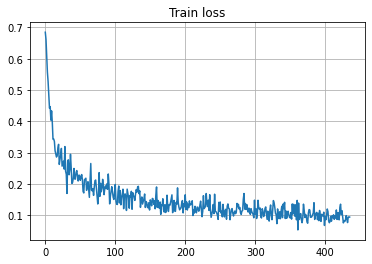

>>> Epoch: 11 Iter: 320/369 Loss: 0.0958668515086174         last epoch acc 0.9180555555555555
>>> Epoch: 11 Iter: 340/369 Loss: 0.16485682129859924         last epoch acc 0.9180555555555555
>>> Epoch: 11 Iter: 360/369 Loss: 0.11930620670318604         last epoch acc 0.9180555555555555


In [1145]:
N_EPOCHS = 12
loss_hist = []
loss_buff = []
epoch_val_hist = [0.5]
for epoch in range(N_EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        inputs = data['img'].unsqueeze(1)
        targets = data['label']
        
#         print(inputs)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        loss_buff.append(loss.item())
        if len(loss_buff) > 9:
            loss_hist.append(np.mean(loss_buff))
            loss_buff = []
        
        if i % 20 == 0:
            print('>>> Epoch: {} Iter: {}/{} Loss: {}         last epoch acc {}'.format(epoch, i, len(trainloader), loss.item(), epoch_val_hist[-1]))
        
        if i % 100 == 0:
            
            clear_output()
            plt.title("Train loss")
            plt.plot(loss_hist)
            plt.grid()
            plt.show()
        
    pred_eyenet = np.zeros(len(X_test))
    for i in range(len(X_test)):
        p = clf_eyenet(X_test[i])
        tru = y_test[i]
        if p > 0.5:
            pred_eyenet[i] = 1 
    epoch_val_hist.append(accuracy_score(y_test, pred_eyenet))
        

In [1146]:
epoch_val_hist

[0.5,
 0.8375,
 0.8555555555555555,
 0.8694444444444445,
 0.8861111111111111,
 0.8958333333333334,
 0.8888888888888888,
 0.8930555555555556,
 0.9138888888888889,
 0.9041666666666667,
 0.9180555555555555,
 0.9180555555555555,
 0.9180555555555555]

In [1157]:
model_parameters = filter(lambda p: p.requires_grad, net.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

66338

In [968]:
net = net.eval()

### metrics

In [1151]:
pred_eyenet = np.zeros(len(X_test))
for i in range(len(X_test)):
    p = clf_eyenet(X_test[i])
    tru = y_test[i]
    if p > 0.6:
        pred_eyenet[i] = 1   

In [1152]:
calc_metrics(y_test, pred_eyenet)

acc: 0.91528
pre: 0.91429
rec: 0.91168
f1 : 0.91298


In [1156]:
torch.save(net.state_dict(), './eyenet.pt')

# resnext based

In [1036]:
resnext50_32x4d = models.resnext50_32x4d(pretrained=True)

In [1037]:
net = nn.Sequential(*list(resnext50_32x4d.children())[:5],
                          nn.MaxPool2d(8),
                          nn.Dropout(0.2),
                          nn.Flatten(),
                          nn.Linear(256, 64),
                          nn.ReLU(),
                          nn.Linear(64, 2)
                         )
net = net.train()

In [1038]:
ATFMS_MRL1 = A.Compose([
    A.CLAHE(clip_limit=1.2, tile_grid_size=(4, 4), p=0.25),
    A.HorizontalFlip(0.5),
    A.Transpose(p=0.01),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.25, rotate_limit=15, p=0.5),
    A.Normalize(mean=0.5, std=0.5),
    A.Resize(32, 32)
])

In [1039]:
ATFMS_MRL2 = A.Compose([
    A.CLAHE(clip_limit=1.2, tile_grid_size=(4, 4), p=0.25),
    A.HorizontalFlip(0.5),
    A.CenterCrop(70, 70),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.25, rotate_limit=15, p=0.5),
    A.Normalize(mean=0.5, std=0.5),
    A.Resize(32, 32)
])

In [1040]:
ATFMS_CUSTOM = A.Compose([
    A.CLAHE(clip_limit=2.5, p=0.1),
    A.HorizontalFlip(0.5),
    A.Normalize(mean=0.5, std=0.5),
    A.Resize(32, 32)
])

In [1041]:
ATFMS_CUSTOM_TEST = A.Compose([
#     A.CLAHE(clip_limit=2.5, p=0.1),
#     A.HorizontalFlip(0.5),
    A.Normalize(mean=0.5, std=0.5),
    A.Resize(32, 32)
])

In [1042]:
class EyesDataset(Dataset):
    def __init__(self, X_custom, Y_custom):
        self.ds_mrl = []
        for fname in sorted(glob('./mrlEyes_2018_01/*/*.png')):
            self.ds_mrl.append({'fname': fname,
                                'label': int(parse_mrl_filename(fname))})
            
        self.ds_mrl = random.sample(self.ds_mrl, 20000)
            
        self.X_custom = X_custom
        self.Y_custom = Y_custom
        print('found: {} mrl, {} custom'.format(len(self.ds_mrl), len(self.X_custom)))

    def __len__(self):
        return len(self.ds_mrl) + len(self.X_custom)

    def __get_custom(self, idx):
        img   = self.X_custom[idx]
        label = self.Y_custom[idx]

        img = ATFMS_MRL1(image=img)['image']
        
        return {'img': img, 'label': label}
    
    def __get_mrl(self, idx):
        item = self.ds_mrl[idx]
        fname = item['fname']
        label = item['label']
        img = cv.imread(fname, cv.IMREAD_GRAYSCALE)
        
        if img.shape[0] > 70:
            img = ATFMS_MRL2(image=img)['image']
        else:
            img = ATFMS_MRL1(image=img)['image']
        
        return {'img': img, 'label': label}
    
    def __getitem__(self, idx):
        if idx < len(self.ds_mrl):
            return self.__get_mrl(idx)
        else:
            return self.__get_custom(idx - len(self.ds_mrl))

In [1043]:
eyes_train_ds = EyesDataset(X_train, y_train)

found: 20000 mrl, 2880 custom


In [1044]:
trainloader = torch.utils.data.DataLoader(eyes_train_ds, batch_size=128, shuffle=True, drop_last=True)

### training

In [1045]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.008)

In [1046]:
def clf_resnet(img):
    img = ATFMS_CUSTOM_TEST(image=img)['image']
    inp_t = torch.tensor(img, dtype=torch.float).unsqueeze(0).unsqueeze(1).repeat(1, 3, 1, 1)
#     print(inp_t.shape)
    with torch.no_grad():
        out = net(inp_t).detach().cpu().numpy().ravel()
    return softmax(out)[1]

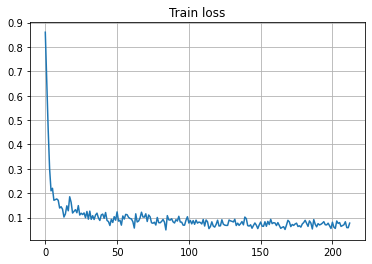

>>> Epoch: 12 Iter: 5/178 Loss: 0.064205601811409         last epoch acc 0.9111111111111111
>>> Epoch: 12 Iter: 10/178 Loss: 0.07828536629676819         last epoch acc 0.9111111111111111
>>> Epoch: 12 Iter: 15/178 Loss: 0.037070270627737045         last epoch acc 0.9111111111111111
>>> Epoch: 12 Iter: 20/178 Loss: 0.11484596133232117         last epoch acc 0.9111111111111111


KeyboardInterrupt: 

In [1048]:
N_EPOCHS = 20
loss_hist = []
loss_buff = []
epoch_val_hist = [0.5]
for epoch in range(N_EPOCHS):
    running_loss = 0.0
    net.train()
    for i, data in enumerate(trainloader, 0):

        inputs = data['img'].unsqueeze(1).repeat(1, 3, 1, 1)
        targets = data['label']
        
#         print(inputs)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        loss_buff.append(loss.item())
        if len(loss_buff) > 9:
            loss_hist.append(np.mean(loss_buff))
            loss_buff = []
        
        if i % 5 == 0:
            print('>>> Epoch: {} Iter: {}/{} Loss: {}         last epoch acc {}'.format(epoch, i, len(trainloader), loss.item(), epoch_val_hist[-1]))
        
        if i % 40 == 0:
            
            clear_output()
            plt.title("Train loss")
            plt.plot(loss_hist)
            plt.grid()
            plt.show()
        
    net.eval()
    pred_eyenet = np.zeros(len(X_test))
    for i in range(len(X_test)):
        p = clf_resnet(X_test[i])
        tru = y_test[i]
        if p > 0.5:
            pred_eyenet[i] = 1 
    epoch_val_hist.append(accuracy_score(y_test, pred_eyenet))
        

In [ ]:
epoch_val_hist

In [1020]:
net = net.eval()

In [1021]:
pred_resnet = np.zeros(len(X_test))
for i in range(len(X_test)):
    p = clf_resnet(X_test[i])
    tru = y_test[i]
    if p > 0.7:
        pred_resnet[i] = 1   

In [1022]:
calc_metrics(y_test, pred_resnet)

acc: 0.90556
pre: 0.87139
rec: 0.94587
f1 : 0.90710


# 